<a href="https://colab.research.google.com/github/neel26desai/cmpe255_assignment3/blob/main/SEMMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/atharvaarya25/phone-usage-dataset

We have the mobile usage data on a single person, data includes at what time does the person one a app and how long will that person be on the app for. Based on this data we need to mine associate rules which can tell us if the person opens App A , which are the other apps that they are more likely to Open. (This is how the suggest app feature in your phone works)

We will be using the SEMMA methodology for performing the associate rule mining.

Note: almost 90% of the code here is written by ChatGPT using, the advanced data analytics plugin.

Prompt:
"User
Activity_history.csv
Spreadsheet
You are playing the role of a senior data scientist, you are assigned a task to develop association rule, regarding if a person opens one app on their phone what are other apps that you could open after than, you asked to create a plan using the SEMMA methodology, and explain your thinking. Give your responses in small chucks and after every step ask me if  I want to continue or make any changes to the logic"

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import pandas as pd
import numpy as np


In [4]:
#before we start with the SEMMA, let us just explore the data
df = pd.read_csv('/content/drive/MyDrive/Activity_history.csv')

In [5]:
df.head(),df.info(),df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   App name  4014 non-null   object
 1   Date      4012 non-null   object
 2   Time      4012 non-null   object
 3   Duration  4012 non-null   object
dtypes: object(4)
memory usage: 125.6+ KB


(                   App name      Date        Time Duration
 0                 App Usage  11/08/23  5:29:39 pm  0:00:01
 1                  WhatsApp  11/08/23  5:28:41 pm  0:00:57
 2                  WhatsApp  11/08/23  5:28:26 pm  0:00:10
 3                 App Usage  11/08/23  5:26:06 pm  0:02:19
 4  Activity history enabled  11/08/23  5:26:06 pm  0:00:00,
 None,
 (4015, 4))

## Sample
1.1 Since the dataset is not too large (4015 entries), we won't need to sample a subset.<br>
1.2 We'll start by performing initial data cleaning to handle missing values and any outliers if necessary.

In [6]:
#check for missing values
df.isna().sum()

App name    1
Date        3
Time        3
Duration    3
dtype: int64

In [12]:
#as the missing value count is small, we can handle it by removing the rows were we have na
df_cleaned=df.dropna()

In [13]:
df_cleaned.info(),df_cleaned.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4012 entries, 0 to 4011
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   App name  4012 non-null   object
 1   Date      4012 non-null   object
 2   Time      4012 non-null   object
 3   Duration  4012 non-null   object
dtypes: object(4)
memory usage: 156.7+ KB


(None, (4012, 4))

Now we have 4012 entries with 0 missing values

## Explore
2.1 We'll perform exploratory data analysis (EDA) to understand the distribution and patterns in the dataset. <br>
2.2 We'll identify the most frequently opened apps.<br>
2.3 We'll look for initial patterns or sequences that could be of interest.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


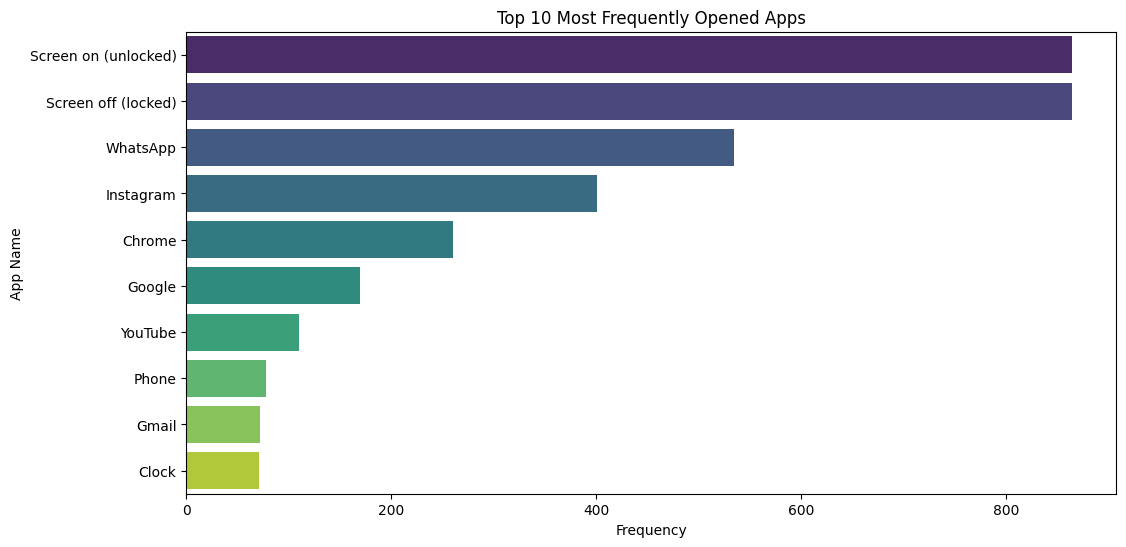

Screen on (unlocked)    864
Screen off (locked)     864
WhatsApp                534
Instagram               401
Chrome                  260
Google                  169
YouTube                 110
Phone                    78
Gmail                    72
Clock                    71
Name: App name, dtype: int64

In [14]:

# Count the frequency of each app name
app_frequency = df_cleaned['App name'].value_counts()

# Displaying the top 10 most frequently opened apps
top_10_apps = app_frequency.nlargest(10)

# Plotting the top 10 most frequently opened apps
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_apps.values, y=top_10_apps.index, palette='viridis')
plt.title('Top 10 Most Frequently Opened Apps')
plt.xlabel('Frequency')
plt.ylabel('App Name')
plt.show()

top_10_apps


From the above representation we can see that screen on and off i.e. unloacking and locking the phone happens way often then opening any other app, however our asscoiate rule shouldn't recommend that the next action is to lock the phone, to prevent this we will remove these 2 actions from our data.

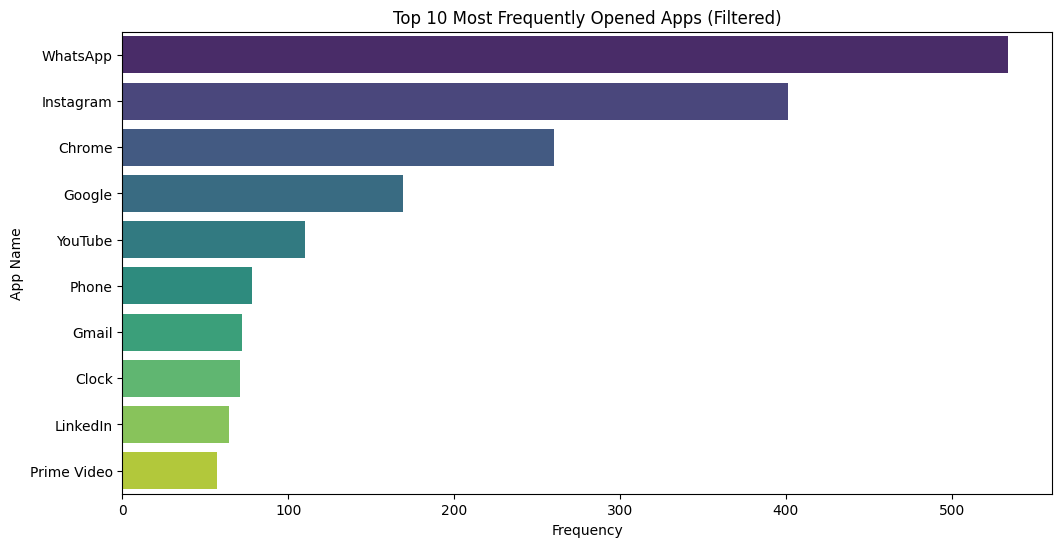

WhatsApp       534
Instagram      401
Chrome         260
Google         169
YouTube        110
Phone           78
Gmail           72
Clock           71
LinkedIn        64
Prime Video     57
Name: App name, dtype: int64

In [15]:
# Removing rows where the 'App name' is 'Screen on (unlocked)' or 'Screen off (locked)'
filtered_df = df_cleaned[~df_cleaned['App name'].isin(['Screen on (unlocked)', 'Screen off (locked)'])]

# Count the frequency of each remaining app name
filtered_app_frequency = filtered_df['App name'].value_counts()

# Displaying the top 10 most frequently opened apps after filtering
top_10_filtered_apps = filtered_app_frequency.nlargest(10)

# Plotting the top 10 most frequently opened apps after filtering
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_filtered_apps.values, y=top_10_filtered_apps.index, palette='viridis')
plt.title('Top 10 Most Frequently Opened Apps (Filtered)')
plt.xlabel('Frequency')
plt.ylabel('App Name')
plt.show()

top_10_filtered_apps


##Modify
3.1 Preprocess the data to a format suitable for association rule mining.<br>
3.2 Encode the sequences of app usage into a transactional format (One-hot encoding).

Grouping by both time and app name will allow us to capture the sequence in which apps are opened in more granular detail. This could provide more accurate association rules.

In [17]:
filtered_df.head()

,App name,Date,Time,Duration
0,App Usage,11/08/23,5:29:39 pm,0:00:01
1,WhatsApp,11/08/23,5:28:41 pm,0:00:57
2,WhatsApp,11/08/23,5:28:26 pm,0:00:10
3,App Usage,11/08/23,5:26:06 pm,0:02:19
4,Activity history enabled,11/08/23,5:26:06 pm,0:00:00


In [18]:
from datetime import datetime

# Combining 'Date' and 'Time' into a single datetime column
filtered_df['Datetime'] = pd.to_datetime(filtered_df['Date'] + ' ' + filtered_df['Time'])

# Sorting the DataFrame by 'Datetime'
filtered_df = filtered_df.sort_values('Datetime')

# Displaying the first few rows of the DataFrame to verify changes
filtered_df.head()


<ipython-input-18-734bd04cd3c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Datetime'] = pd.to_datetime(filtered_df['Date'] + ' ' + filtered_df['Time'])


,App name,Date,Time,Duration,Datetime
4011,WhatsApp,01/08/23,11:47:31 pm,0:01:08,2023-01-08 23:47:31
4010,Google,01/08/23,11:48:44 pm,0:00:04,2023-01-08 23:48:44
4009,Chrome,01/08/23,11:48:48 pm,0:00:37,2023-01-08 23:48:48
4008,Google,01/08/23,11:49:25 pm,0:00:00,2023-01-08 23:49:25
4007,WhatsApp,01/08/23,11:49:27 pm,0:00:05,2023-01-08 23:49:27


In [19]:

# Calculate the time difference between consecutive rows
filtered_df['Time_Diff'] = filtered_df['Datetime'].diff().dt.total_seconds() / 60.0

# Initialize a transaction ID
filtered_df['Transaction_ID'] = 0

# Assign a transaction ID based on the time difference
# A new transaction is assumed to start if the time gap is more than 5 minutes
transaction_id = 0
for i in range(1, len(filtered_df)):
    if filtered_df.iloc[i]['Time_Diff'] > 5:
        transaction_id += 1
    filtered_df.at[filtered_df.index[i], 'Transaction_ID'] = transaction_id

# Display the first few rows to verify transaction IDs
filtered_df.head(10)


,App name,Date,Time,Duration,Datetime,Time_Diff,Transaction_ID
4011,WhatsApp,01/08/23,11:47:31 pm,0:01:08,2023-01-08 23:47:31,NaN,0
4010,Google,01/08/23,11:48:44 pm,0:00:04,2023-01-08 23:48:44,1.216667,0
4009,Chrome,01/08/23,11:48:48 pm,0:00:37,2023-01-08 23:48:48,0.066667,0
4008,Google,01/08/23,11:49:25 pm,0:00:00,2023-01-08 23:49:25,0.616667,0
4007,WhatsApp,01/08/23,11:49:27 pm,0:00:05,2023-01-08 23:49:27,0.033333,0
4006,WhatsApp,01/08/23,11:49:37 pm,0:00:08,2023-01-08 23:49:37,0.166667,0
4003,WhatsApp,01/08/23,11:50:06 pm,0:00:01,2023-01-08 23:50:06,0.483333,0
4002,Instagram,01/08/23,11:50:11 pm,0:01:07,2023-01-08 23:50:11,0.083333,0
4001,WhatsApp,01/08/23,11:51:20 pm,0:08:53,2023-01-08 23:51:20,1.150000,0
3998,WhatsApp,02/08/23,12:04:49 am,0:00:41,2023-02-08 00:04:49,43213.483333,1


In [20]:
# Grouping the data by 'Transaction_ID' and creating a list of apps for each transaction
transaction_data = filtered_df.groupby('Transaction_ID')['App name'].apply(list).reset_index(name='Transaction')

# Manually performing one-hot encoding for transactional data
unique_apps = filtered_df['App name'].unique()
one_hot_encoded_data = []

for transaction in transaction_data['Transaction']:
    encoded_row = {app: 0 for app in unique_apps}
    for app in transaction:
        encoded_row[app] = 1
    one_hot_encoded_data.append(encoded_row)

# Converting the list of dictionaries to a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded_data)

# Display the first few rows of the one-hot encoded DataFrame
one_hot_df.head()


,WhatsApp,Google,Chrome,Instagram,Snapchat,Wireless Earphones,Prime Video,Clock,Phone,Truecaller,...,Telegram,McDonald's,McDelivery,Docs,Screenshot,Breeze,Gymshark,Manage notifications,App Usage,Activity history enabled
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Model
4.1 Apply the Apriori algorithm to find frequent itemsets.<br>
4.2 Generate association rules based on these frequent itemsets. <br>
4.3 Determine metrics like support, confidence, and lift for evaluation.

In [21]:
# Manually implementing the Apriori algorithm to find frequent itemsets

# Calculate the support for each individual app
support_single = one_hot_df.mean()

# Filter apps that have a support greater than a given threshold (e.g., 0.1 or 10%)
min_support = 0.1
frequent_single = support_single[support_single >= min_support]

# Display frequent single-item itemsets
frequent_single.sort_values(ascending=False)


Instagram    0.478261
WhatsApp     0.438923
Chrome       0.198758
YouTube      0.159420
Google       0.122153
Gmail        0.111801
dtype: float64

In [22]:
# Initialize an empty list to store the association rules and their metrics
association_rules = []

# Loop through each pair of frequent single-item itemsets to generate association rules
for i, app1 in enumerate(frequent_single.index):
    for j, app2 in enumerate(frequent_single.index):
        if app1 != app2:
            # Calculate Support for {app1, app2}
            support_pair = len(one_hot_df[(one_hot_df[app1] == 1) & (one_hot_df[app2] == 1)]) / len(one_hot_df)

            # Calculate Confidence for the rule {app1} => {app2}
            confidence = support_pair / frequent_single[app1]

            # Store the association rule and its metrics
            association_rules.append({'Rule': f"{app1} => {app2}", 'Support': support_pair, 'Confidence': confidence})

# Convert the list of dictionaries to a DataFrame
association_rules_df = pd.DataFrame(association_rules)

# Sort the DataFrame by Confidence in descending order
association_rules_df = association_rules_df.sort_values(by='Confidence', ascending=False)

# Display the association rules
association_rules_df.head()


,Rule,Support,Confidence
6,Google => Chrome,0.091097,0.745763
7,Google => Instagram,0.082816,0.677966
5,Google => WhatsApp,0.080745,0.661017
23,Gmail => Instagram,0.068323,0.611111
10,Chrome => WhatsApp,0.115942,0.583333


## Access


In [23]:
# Filter the association rules where the antecedent is 'WhatsApp'
whatsapp_rules = association_rules_df[association_rules_df['Rule'].str.startswith('WhatsApp =>')]

# Display the association rules for 'WhatsApp'
whatsapp_rules


,Rule,Support,Confidence
2,WhatsApp => Instagram,0.223602,0.509434
1,WhatsApp => Chrome,0.115942,0.264151
0,WhatsApp => Google,0.080745,0.183962
4,WhatsApp => YouTube,0.057971,0.132075
3,WhatsApp => Gmail,0.051760,0.117925


Based on userfeedback, this connections make senses

In [24]:
# Initialize an empty list to store the association rules and their metrics
association_rules = []

# Loop through each pair of frequent itemsets (here, single-item itemsets) to generate rules
for i, app1 in enumerate(frequent_single.index):
    for j, app2 in enumerate(frequent_single.index):
        if app1 != app2:
            # Calculate Support for the pair {app1, app2}
            support_pair = len(one_hot_df[(one_hot_df[app1] == 1) & (one_hot_df[app2] == 1)]) / len(one_hot_df)

            # Calculate Confidence for the rule {app1} => {app2}
            confidence = support_pair / frequent_single[app1]

            # Calculate Lift for the rule {app1} => {app2} (Optional)
            lift = support_pair / (frequent_single[app1] * frequent_single[app2])

            # Store the association rule and its metrics in a dictionary
            rule_metrics = {'Rule': f"{app1} => {app2}", 'Support': support_pair, 'Confidence': confidence, 'Lift': lift}

            # Append the dictionary to the list
            association_rules.append(rule_metrics)

# Convert the list of dictionaries to a DataFrame for easier analysis
import pandas as pd
association_rules_df = pd.DataFrame(association_rules)

# Sort the DataFrame by desired metric (e.g., Confidence, Lift)
sorted_rules = association_rules_df.sort_values(by='Confidence', ascending=False)

# Display or save the sorted rules
print(sorted_rules)


                     Rule   Support  Confidence      Lift
6        Google => Chrome  0.091097    0.745763  3.752119
7     Google => Instagram  0.082816    0.677966  1.417565
5      Google => WhatsApp  0.080745    0.661017  1.505996
23     Gmail => Instagram  0.068323    0.611111  1.277778
10     Chrome => WhatsApp  0.115942    0.583333  1.329009
2   WhatsApp => Instagram  0.223602    0.509434  1.065180
12    Chrome => Instagram  0.099379    0.500000  1.045455
15  Instagram => WhatsApp  0.223602    0.467532  1.065180
20      Gmail => WhatsApp  0.051760    0.462963  1.054769
11       Chrome => Google  0.091097    0.458333  3.752119
22        Gmail => Chrome  0.041408    0.370370  1.863426
25    YouTube => WhatsApp  0.057971    0.363636  0.828473
28   YouTube => Instagram  0.057971    0.363636  0.760331
1      WhatsApp => Chrome  0.115942    0.264151  1.329009
27      YouTube => Chrome  0.037267    0.233766  1.176136
13        Chrome => Gmail  0.041408    0.208333  1.863426
17    Instagra

In [25]:
# Save the association rules DataFrame to a CSV file
association_rules_df.to_csv('/content/drive/MyDrive/association_rules.csv', index=False)

In [30]:
def predict_next_app(current_app, association_rules_df):
    # Filter rules where the antecedent is the current_app
    relevant_rules = association_rules_df[association_rules_df['Rule'].str.startswith(f"{current_app} =>")]

    # Sort the relevant_rules DataFrame by Confidence in descending order
    sorted_rules = relevant_rules.sort_values(by='Confidence', ascending=False)

    # If there are no relevant rules, return a message
    if sorted_rules.empty:
        return f"No rules found for {current_app}. Cannot make a prediction."

    # Otherwise, get the consequent of the rule with the highest confidence
    top_rule = sorted_rules.iloc[0]
    next_app = top_rule['Rule'].split(" => ")[1]

    return f"The user is most likely to open {next_app} next after using {current_app}."

In [31]:
predict_next_app("YouTube",association_rules_df)

'The user is most likely to open WhatsApp next after using YouTube.'

References:

[1]https://www.datascience-pm.com/semma/